# Performance Comparisons

We want to compare against several other packages on standard problems:

* GUDHI
* Dionysus
* Ripser
* TopologyLayer
* BATS standard with and without basis formation
* BATS clearing/compression optimizations (no basis)

Note TopologyLayer requires pytorch 1.1
```
conda install pytorch=1.1 -c pytorch
```

Dionysus and Gudhi can be installed via pip
```
pip install dionyusus gudhi
```

Ripser apparently has some issues with compilation, but this did the trick
```
CFLAGS="-DNPY_NO_DEPRECATED_API -DNPY_1_7_API_VERSION -include limits" pip install --upgrade ripser
```

Write wrapper functions.  Take as input either two images or two metric spaces

In [1]:
import bats
import numpy as np
import matplotlib.pyplot as plt
import time
from freudenthal import freudenthal_grid
import gudhi as gd
import dionysus as d
import ripser

# Levelset Comparison

In [2]:
m = 200
n = 200

def kendall_tau_distance(vals1, vals2):
    """
    compute kendall-tau distance between sort permutations for vals1, vals2
    """
    kd = 0
    nmax = 0
    for v1, v2 in zip(vals1, vals2):
        perm1 = np.argsort(v1, kind='stable')
        perm2 = np.argsort(v2, kind='stable')

        nperm = len(perm1)
        maxswaps = (nperm * (nperm-1)) // 2

        kt = bats.kendall_tau(perm1, perm2)
        kd += kt
        nmax += maxswaps
        
    return kd, nmax

def print_kt(img1, img2):
    m, n = img1.shape
    X = freudenthal_grid(m, n)
    vals, imap = bats.lower_star_filtration(X, img1.flatten())
    vals2, imap = bats.lower_star_filtration(X, img2.flatten())
    kd, nmax = kendall_tau_distance(vals, vals2)
    print("Kendall-tau distance / max = {}".format(kd / nmax))

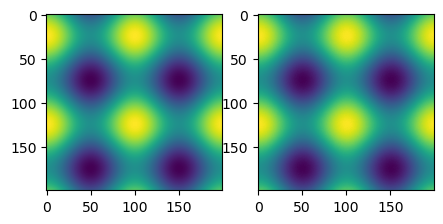

Kendall-tau distance / max = 0.0033484259613554375


In [3]:
f = np.empty((m,n))
for i in range(m):
    for j in range(n):
        f[i,j] = np.sin(4*np.pi*i/m) + np.cos(4*np.pi*j/n)

sigma = 0.01
f2 = f + sigma*np.random.randn(m,n)
fig, ax = plt.subplots(1,2, figsize=(5,10))
ax[0].imshow(f)
ax[1].imshow(f2)
plt.show()
print_kt(f, f2)

### BATS update:

In [4]:



def time_BATS_update(img, img2, *flags):
    m, n = img.shape
    X = freudenthal_grid(m, n)
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    t1 = time.monotonic()
    print("time to extend: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.FilteredSimplicialComplex(X, vals)
    t1 = time.monotonic()
    print("time to construct: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2(), *flags)
#     R = bats.reduce(F, bats.F2(), bats.standard_reduction_flag(), bats.compute_basis_flag())
    t1 = time.monotonic()
    print("time to reduce: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    vals2, imap = bats.lower_star_filtration(X, img2.flatten())
    R.update_filtration(vals2)
    t1 = time.monotonic()
    print("time to update: {} sec.".format(t1 - t0))
    
    kd, nmax = kendall_tau_distance(vals, vals2)
    print("Kendall-tau distance / max = {}".format(kd / nmax))
    
time_BATS_update(f, f2)
print("\nwith clearing+basis")
time_BATS_update(f, f2, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())

time to extend: 0.04081001100712456 sec.
time to construct: 0.06327187400893308 sec.
time to reduce: 1.0406032280006912 sec.
time to update: 0.18652568699326366 sec.
Kendall-tau distance / max = 0.0033484259613554375

with clearing+basis
time to extend: 0.0354586869943887 sec.
time to construct: 0.046318150009028614 sec.
time to reduce: 0.27045476401690394 sec.
time to update: 0.09594849700806662 sec.
Kendall-tau distance / max = 0.0033484259613554375


### BATS with flags

In [8]:
def time_BATS_flags(img, img2, flags=(bats.standard_reduction_flag(), bats.compute_basis_flag())):
    m, n = img.shape
    X = freudenthal_grid(m, n)
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    R = bats.reduce(F, bats.F2(), *flags)
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img2.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    R = bats.reduce(F, bats.F2(), *flags)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    
    
flags = [
    (bats.standard_reduction_flag(), bats.compute_basis_flag()),
    (bats.standard_reduction_flag(),),
    (bats.standard_reduction_flag(), bats.clearing_flag()),
    (bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag()),
    (bats.standard_reduction_flag(), bats.compression_flag()),
    (bats.extra_reduction_flag(), bats.compute_basis_flag()),
    (bats.extra_reduction_flag(),),
    (bats.extra_reduction_flag(), bats.clearing_flag()),
    (bats.extra_reduction_flag(), bats.compression_flag()),
]
labels = [
    "standard w/ basis",
    "standard w/ no basis",
    "standard w/ clearing",
    "standard w/ clearing basis",
    "standard w/ compression",
    "extra w/ basis",
    "extra w/ no basis",
    "extra w/ clearing",
    "extra w/ compression"
]
for flag, label in zip(flags, labels):
    print("\n{}:".format(label))
    time_BATS_flags(f, f2, flag)



standard w/ basis:
compute1: 1.0358699949865695 sec.
compute2: 0.9782230620039627 sec.

standard w/ no basis:
compute1: 0.30192782601807266 sec.
compute2: 0.3228436990175396 sec.

standard w/ clearing:
compute1: 0.14681747899157926 sec.
compute2: 0.222033405007096 sec.

standard w/ clearing basis:
compute1: 0.35377186301047914 sec.
compute2: 0.41871322999941185 sec.

standard w/ compression:
compute1: 0.27825963898794726 sec.
compute2: 0.3382817569945473 sec.

extra w/ basis:
compute1: 0.9311037480074447 sec.
compute2: 0.9755500729952473 sec.

extra w/ no basis:
compute1: 0.2914147459960077 sec.
compute2: 0.37116803700337186 sec.

extra w/ clearing:
compute1: 0.15511774198967032 sec.
compute2: 0.22339931697933935 sec.

extra w/ compression:
compute1: 0.31164661500952207 sec.
compute2: 0.3607354960113298 sec.


### TopologyLayer:

In [6]:
# from topologylayer.nn import LevelSetLayer2D
# from topologylayer.nn import RipsLayer
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# import time

In [8]:
m = 200
n = 200
f = np.empty((m,n))
for i in range(m):
    for j in range(n):
        f[i,j] = np.sin(4*np.pi*i/m) + np.cos(4*np.pi*j/n)

f2 = f + 0.01*np.random.randn(m,n)

In [9]:
# def time_toplayer(img, img2):
    
#     layer = LevelSetLayer2D(size=img.shape)
#     img_t = torch.tensor(img, dtype=torch.float, requires_grad=False)
#     img2_t = torch.tensor(img2, dtype=torch.float, requires_grad=False)
    
#     t0 = time.monotonic()
#     pds = layer(img_t)
#     t1 = time.monotonic()
#     print("compute1: {} sec.".format(t1 - t0))
    
#     t0 = time.monotonic()
#     pds = layer(img2_t)
#     t1 = time.monotonic()
#     print("compute2: {} sec.".format(t1 - t0))

    
# time_toplayer(f, f2)

### GUDHI: see http://gudhi.gforge.inria.fr/python/latest/simplex_tree_ref.html

In [10]:
def construct_gudhi_simplex_tree(img):
    # create in BATS to dump
    X = freudenthal_grid(*img.shape)
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    
    t0 = time.monotonic()
    GT = gd.SimplexTree()
    for k in range(F.maxdim() + 1):
        for s, v in zip(X.get_simplices(k), F.vals(k)):
            GT.insert(s, v)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    return GT

def update_gudhi_simplex_tree(tree, img):
    # create in BATS to dump
    X = freudenthal_grid(*img.shape)
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    
    t0 = time.monotonic()
    for k in range(F.maxdim() + 1):
        for s, v in zip(X.get_simplices(k), F.vals(k)):
            tree.assign_filtration(s, v)
    t1 = time.monotonic()
    print("update values: {} sec.".format(t1 - t0))
    return tree

def time_gudhi(img, img2):
    GT = construct_gudhi_simplex_tree(img)
    t0 = time.monotonic()
    diag = GT.persistence()
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    GT = update_gudhi_simplex_tree(GT, img2)
    t0 = time.monotonic()
    diag = GT.persistence()
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    
time_gudhi(f, f2)

construction: 0.3209149369795341 sec.
compute1: 0.11101125500863418 sec.
update values: 0.24447176299872808 sec.
compute2: 0.11048428399953991 sec.


### Dionysus: https://mrzv.org/software/dionysus2/tutorial/lower-star.html

In [11]:
def time_dionysus(img, img2):
    t0 = time.monotonic()
    f_lower_star = d.fill_freudenthal(img)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    t1 = time.monotonic()
    print("persistence: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    f_lower_star = d.fill_freudenthal(img2)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    t1 = time.monotonic()
    print("persistence: {} sec.".format(t1 - t0))
    
time_dionysus(f, f2)

construction: 0.1763250639778562 sec.
persistence: 0.1533896290056873 sec.
construction: 0.21757725102361292 sec.
persistence: 0.16610032401513308 sec.


### Ripser: https://ripser.scikit-tda.org/en/latest/notebooks/Lower%20Star%20Image%20Filtrations.html

In [11]:
dgm = ripser.lower_star_img(f)

In [12]:
def time_ripser(img, img2):
    t0 = time.monotonic()
    dgm = ripser.lower_star_img(img)
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    dgm = ripser.lower_star_img(img2)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    
time_ripser(f, f2)

compute1: 0.11133915800019167 sec.
compute2: 0.09454485698370263 sec.


### BATS DGVS

In [7]:
def time_bats_dgvs(img, img2, *flags):
    m, n = img.shape
    X = bats.Freudenthal(m, n)
    
    for degree in [+1, -1]:
        print("degree = {:+d}".format(degree))
        
        t0 = time.monotonic()
        vals, imax = bats.lower_star_filtration(X, img.flatten()) # computes filtration parameter to
        F = bats.Filtration(X, vals)
        FC = bats.FilteredF2DGVectorSpace(F, degree)
        RC = bats.ReducedFilteredF2DGVectorSpace(FC, *flags)
        t1 = time.monotonic()
        print("{:.3f} sec. to compute1".format(t1 - t0))
        
        t0 = time.monotonic()
        vals2, imap2 = bats.lower_star_filtration(X, img2.flatten()) # computes filtration parameter to
        RC.update_filtration(vals2)
        t1 = time.monotonic()
        print("{:.3f} sec. to update".format(t1 - t0))
        
        t0 = time.monotonic()
        vals, imax = bats.lower_star_filtration(X, img2.flatten()) # computes filtration parameter to
        F = bats.Filtration(X, vals)
        FC = bats.FilteredF2DGVectorSpace(F, degree)
        RC = bats.ReducedFilteredF2DGVectorSpace(FC, *flags)
        t1 = time.monotonic()
        print("{:.3f} sec. to compute2".format(t1 - t0))
        
        
print("with clearing")
time_bats_dgvs(f, f2, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
print("no clearing")
time_bats_dgvs(f, f2, bats.standard_reduction_flag(), bats.compute_basis_flag())

with clearing
degree = +1
2.174 sec. to compute1
0.113 sec. to update
2.373 sec. to compute2
degree = -1
0.547 sec. to compute1
0.109 sec. to update
0.560 sec. to compute2
no clearing
degree = +1
2.984 sec. to compute1
0.189 sec. to update
3.118 sec. to compute2
degree = -1
1.180 sec. to compute1
0.191 sec. to update
1.189 sec. to compute2


# Rips Complex

In [14]:
# first, generate two noisy circles
n = 40
Y = np.random.normal(size=(n,2))
Y = Y / np.linalg.norm(Y, axis=1).reshape(-1,1)
Y = Y + np.random.normal(size=(n,2), scale = 0.1 )

Y[:20,0] = Y[:20,0] - 1
Y[20:,0] = Y[20:,0] + 1
fig = plt.scatter(Y[:,0], Y[:,1])

Y2 = Y + 0.01*np.random.randn(n,2)

In [15]:
def time_BATS_update_rips(X, Y):
    dist = bats.Euclidean()  # distance we would like to use
    
    data = bats.DataSet(bats.Matrix(X)) # put into a bats.DataSet
    data_Y = bats.DataSet(bats.Matrix(Y)) # put into a bats.DataSet
    
    t0 = time.monotonic()
    F_X = bats.RipsFiltration(data, dist, np.inf, 2) # generate a RipsFiltration
    t1 = time.monotonic()
    print("time to construct: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R_X = bats.reduce(F_X, bats.F2()) # reduce with F2 coefficients
    t1 = time.monotonic()
    print("time to reduce: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F_Y = bats.RipsFiltration(data_Y, dist, np.inf, 2) # generate a RipsFiltration
    UI = bats.UpdateInfoFiltration(F_X, F_Y)
    R_X.update_filtration_general(UI)
    t1 = time.monotonic()
    print("time to update: {} sec.".format(t1 - t0))
    
time_BATS_update_rips(Y, Y2)

time to construct: 0.017494792002253234 sec.
time to reduce: 0.02116194600239396 sec.
time to update: 0.024248756992165 sec.


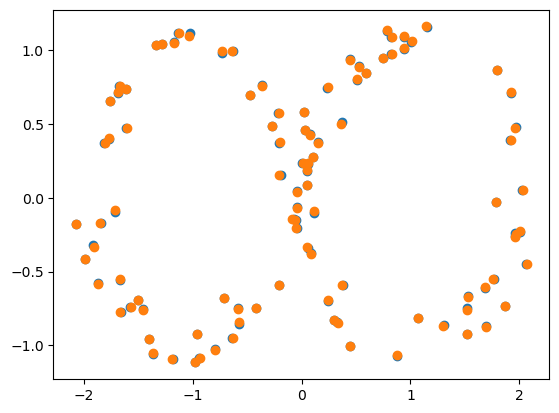

In [19]:
# first, generate two noisy circles
n = 100
Y = np.random.normal(size=(n,2))
Y = Y / np.linalg.norm(Y, axis=1).reshape(-1,1)
Y = Y + np.random.normal(size=(n,2), scale = 0.1 )

Y[:(n//2),0] = Y[:(n//2),0] - 1
Y[(n//2):,0] = Y[(n//2):,0] + 1
fig = plt.scatter(Y[:,0], Y[:,1])

Y2 = Y + 0.005*np.random.randn(n,2)
plt.scatter(Y2[:,0], Y2[:,1])
plt.show()

In [15]:
# # Don't run this for larger problems 
# def time_toplayer_rips(y, y2):
    
#     # layer = LevelSetLayer2D(size=img.shape)
#     layer = RipsLayer(y.shape[0], maxdim=1) # maxdim is homology dimension
#     y_t = torch.tensor(y, dtype=torch.float, requires_grad=False)
#     y2_t = torch.tensor(y2, dtype=torch.float, requires_grad=False)
    
#     t0 = time.monotonic()
#     pds = layer(y_t)
#     t1 = time.monotonic()
#     print("compute1: {} sec.".format(t1 - t0))
    
#     t0 = time.monotonic()
#     pds = layer(y2_t)
#     t1 = time.monotonic()
#     print("compute2: {} sec.".format(t1 - t0))

    
# time_toplayer_rips(Y, Y2)

compute1: 8.381071571988286 sec.
compute2: 8.324954397976398 sec.


Compared to TopologyLayer, BATs is much faster!!!! Rips Complex with 40 points in bats is faster than even 20 points in TopologyLayer!

It seems unnecessary for Gudhi to update simplex tree? (Need to write new python bindings for Updating information)

In [20]:
def time_gudhi_rips(X, Y):
    
    t0 = time.monotonic()
    rips_complex = gd.RipsComplex(points=X, max_edge_length=np.inf)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence()
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    # need to include setup
    rips_complex = gd.RipsComplex(points=Y, max_edge_length=np.inf)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence()
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    
time_gudhi_rips(Y, Y2)

compute1: 0.0849329589982517 sec.
compute2: 0.06856220602639951 sec.


In [31]:
rips_complex = gd.RipsComplex(points=Y, max_edge_length=np.inf)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
diag = simplex_tree.persistence()

In [34]:
simplex_tree.persistence?

Gudhi seems to have a good performance. 

In [22]:
def time_dionysus_rips(X, Y):
    
    t0 = time.monotonic()
    f = d.fill_rips(X, 2, np.inf)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    p = d.homology_persistence(f)
    dgms = d.init_diagrams(p, f)
    t1 = time.monotonic()
    print("persistence: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    p = d.cohomology_persistence(f)
    dgms = d.init_diagrams(p, f)
    t1 = time.monotonic()
    print("cohom persistence: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    f = d.fill_rips(Y, 2, np.inf)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    p = d.homology_persistence(f)
    dgms = d.init_diagrams(p, f)
    t1 = time.monotonic()
    print("persistence: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    p = d.cohomology_persistence(f)
    dgms = d.init_diagrams(p, f)
    t1 = time.monotonic()
    print("cohom persistence: {} sec.".format(t1 - t0))
    
time_dionysus_rips(Y, Y2)

construction: 0.6052072099992074 sec.
persistence: 0.7055191289982758 sec.
cohom persistence: 0.09899808000773191 sec.
construction: 0.6449307300208602 sec.
persistence: 0.6943102270015515 sec.
cohom persistence: 0.10196565100341104 sec.


## Ripser

In [9]:
?ripser.lower_star_img

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


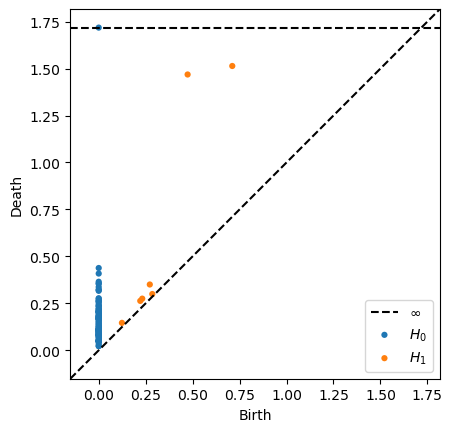

In [25]:
import numpy as np
from ripser import Rips

rips = Rips(maxdim=1)
diagrams = rips.fit_transform(Y)
rips.plot(diagrams)
plt.show()

In [26]:
def time_ripser_rips(X, Y, **kw):
    
    t0 = time.monotonic()
    out = ripser.ripser(X, **kw)
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    out2 = ripser.ripser(Y, **kw)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))

print("no basis")
time_ripser_rips(Y, Y2, maxdim=1)

print("with basis")
time_ripser_rips(Y, Y2, do_cocycles=True, maxdim=1)

no basis
compute1: 0.012306515011005104 sec.
compute2: 0.008148507011355832 sec.
with basis
compute1: 0.008675418008351699 sec.
compute2: 0.008260806003818288 sec.


## BATS

DGVS

In [30]:
import scipy.spatial.distance as distance

def time_BATS_rips(X, Y, *flags):
    
    for deg in {+1, -1}:
        print("degree {:+d}".format(deg))
        
        t0 = time.monotonic()
        D = distance.squareform(distance.pdist(X))
        rX = bats.enclosing_radius(bats.Matrix(D))
        F = bats.LightRipsFiltration(bats.Matrix(D), rX, 2)
        t0a = time.monotonic()
        FC = bats.FilteredF2DGVectorSpace(F, deg)
        FR = bats.ReducedFilteredF2DGVectorSpace(FC, *flags)
        t1 = time.monotonic()
        print("Space 1: {} sec.".format(t1 - t0))
        print("\tsetup: {} sec.".format(t0a - t0))
        print("\treduction: {} sec.".format(t1 - t0a))

        t0 = time.monotonic()
        D = distance.squareform(distance.pdist(Y))
        rX = bats.enclosing_radius(bats.Matrix(D))
        F = bats.LightRipsFiltration(bats.Matrix(D), rX, 2)
        t0a = time.monotonic()
        FC = bats.FilteredF2DGVectorSpace(F, deg)
        FR = bats.ReducedFilteredF2DGVectorSpace(FC, *flags)
        t1 = time.monotonic()
        print("Space 2: {} sec.".format(t1 - t0))
        print("\tsetup: {} sec.".format(t0a - t0))
        print("\treduction: {} sec.".format(t1 - t0a))
    

print("\nno clearing:")
time_BATS_rips(Y, Y2)
print("\nwith clearing:")
time_BATS_rips(Y, Y2, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())


no clearing:
degree +1
Space 1: 1.285356929001864 sec.
	setup: 0.029736901982687414 sec.
	reduction: 1.2556200270191766 sec.
Space 2: 1.1457485339778941 sec.
	setup: 0.020017167000332847 sec.
	reduction: 1.1257313669775613 sec.
degree -1
Space 1: 0.20056936700711958 sec.
	setup: 0.021838315995410085 sec.
	reduction: 0.1787310510117095 sec.
Space 2: 0.22805343300569803 sec.
	setup: 0.02612301500630565 sec.
	reduction: 0.20193041799939238 sec.

with clearing:
degree +1
Space 1: 0.06230090800090693 sec.
	setup: 0.021467193990247324 sec.
	reduction: 0.040833714010659605 sec.
Space 2: 0.06163535299128853 sec.
	setup: 0.01992715199594386 sec.
	reduction: 0.04170820099534467 sec.
degree -1
Space 1: 0.19980965001741424 sec.
	setup: 0.020829632005188614 sec.
	reduction: 0.17898001801222563 sec.
Space 2: 0.20756529597565532 sec.
	setup: 0.02466856499086134 sec.
	reduction: 0.18289673098479398 sec.


original chain approach

In [28]:
import scipy.spatial.distance as distance

def time_BATS_rips(X, Y):
    
    t0 = time.monotonic()
    DX = distance.squareform(distance.pdist(X))
    rX = bats.enclosing_radius(bats.Matrix(DX))
    t1 = time.monotonic()
    print("setup1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.LightRipsFiltration(bats.Matrix(DX), rX, 2)
    t1 = time.monotonic()
    print("construct1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2())
    t1 = time.monotonic()
    print("reduce1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    DY = distance.squareform(distance.pdist(Y))
    rY = bats.enclosing_radius(bats.Matrix(DY))
    t1 = time.monotonic()
    print("setup2: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.LightRipsFiltration(bats.Matrix(DY), rY, 2)
    t1 = time.monotonic()
    print("construct2: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2())
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    

time_BATS_rips(Y, Y2)

setup1: 0.0005621319869533181 sec.
construct1: 0.01876024901866913 sec.
reduce1: 0.16133692898438312 sec.
setup2: 0.0003569000109564513 sec.
construct2: 0.018640405993210152 sec.
compute2: 0.16677312899264507 sec.


with flags...

In [29]:
def time_BATS_rips_flags(X, Y, flags=(bats.standard_reduction_flag(), bats.compute_basis_flag())):
    
    t0 = time.monotonic()
    DX = distance.squareform(distance.pdist(X))
    rX = bats.enclosing_radius(bats.Matrix(DX))
    t1 = time.monotonic()
    print("setup1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.LightRipsFiltration(bats.Matrix(DX), rX, 2)
    t1 = time.monotonic()
    print("construct1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2(), *flags)
    t1 = time.monotonic()
    print("reduce1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    DY = distance.squareform(distance.pdist(Y))
    rY = bats.enclosing_radius(bats.Matrix(DY))
    t1 = time.monotonic()
    print("setup2: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.LightRipsFiltration(bats.Matrix(DY), rY, 2)
    t1 = time.monotonic()
    print("construct2: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2(), *flags)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    
    
flags = [
    (bats.standard_reduction_flag(), bats.compute_basis_flag()),
    (bats.standard_reduction_flag(),),
    (bats.standard_reduction_flag(), bats.clearing_flag()),
    (bats.standard_reduction_flag(), bats.compression_flag()),
    (bats.extra_reduction_flag(), bats.compute_basis_flag()),
    (bats.extra_reduction_flag(),),
    (bats.extra_reduction_flag(), bats.clearing_flag()),
    (bats.extra_reduction_flag(), bats.compression_flag()),
]
labels = [
    "standard w/ basis",
    "standard w/ no basis",
    "standard w/ clearing",
    "standard w/ compression",
    "extra w/ basis",
    "extra w/ no basis",
    "extra w/ clearing",
    "extra w/ compression"
]
for flag, label in zip(flags, labels):
    print("\n{}:".format(label))
    time_BATS_rips_flags(Y, Y2, flag)


standard w/ basis:
setup1: 0.0009315100032836199 sec.
construct1: 0.017519287997856736 sec.
reduce1: 0.16445550898788497 sec.
setup2: 0.0004174390051048249 sec.
construct2: 0.016487811983097345 sec.
compute2: 0.15952101501170546 sec.

standard w/ no basis:
setup1: 0.0003045730118174106 sec.
construct1: 0.01687272300478071 sec.
reduce1: 0.09310991098755039 sec.
setup2: 0.00014320301124826074 sec.
construct2: 0.016404927999246866 sec.
compute2: 0.0908332199905999 sec.

standard w/ clearing:
setup1: 0.00022373002138920128 sec.
construct1: 0.01448466198053211 sec.
reduce1: 0.08839080500183627 sec.
setup2: 0.0008166299958247691 sec.
construct2: 0.01778711099177599 sec.
compute2: 0.0985572490026243 sec.

standard w/ compression:
setup1: 0.0003552089910954237 sec.
construct1: 0.016123491019243374 sec.
reduce1: 0.10037682400434278 sec.
setup2: 0.0001688519841991365 sec.
construct2: 0.020873168017715216 sec.
compute2: 0.10268210200592875 sec.

extra w/ basis:
setup1: 0.00022862598416395485 sec

Now, let's do with updates

In [23]:
def time_BATS_updates_rips(X, Y):
    
    t0 = time.monotonic()
    DX = distance.squareform(distance.pdist(X))
    rX = bats.enclosing_radius(bats.Matrix(DX))
    t1 = time.monotonic()
    print("setup1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.LightRipsFiltration(bats.Matrix(DX), rX, 2)
    t1 = time.monotonic()
    print("construct1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2())
    t1 = time.monotonic()
    print("reduce1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    DY = distance.squareform(distance.pdist(Y))
    rY = bats.enclosing_radius(bats.Matrix(DY))
    t1 = time.monotonic()
    print("setup2: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    FY = bats.LightRipsFiltration(bats.Matrix(DY), rY, 2)
    t1 = time.monotonic()
    print("construct2: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    update_info = bats.UpdateInfoLightFiltration(F, FY)
    R.update_filtration_general(update_info)
    t1 = time.monotonic()
    print("update2: {} sec.".format(t1 - t0))
    

time_BATS_updates_rips(Y, Y2)

setup1: 0.0002264019858557731 sec.
construct1: 0.024035700014792383 sec.
reduce1: 0.24715175898745656 sec.
setup2: 0.0007699599955230951 sec.
construct2: 0.024273275019368157 sec.
update2: 0.09535754099488258 sec.
